CO2データのみで実行する

可視化

In [1]:
import statsmodels.datasets.co2 as co2
import pandas as pd

co2_data = co2.load().data

#1981年以降のデータのみ
co2_data = co2_data.iloc[1188:]

# 'date'カラムをdatetime型として設定し、インデックスとして使用
co2_data.index = pd.to_datetime(co2_data.index)

# 月次データに変換 (月の最終日を取得)
co2_data = co2_data.resample('M').mean()
co2_data.head()

<ipython-input-1-515d42234649>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  co2_data = co2_data.resample('M').mean()


,co2
1981-01-31,339.22
1981-02-28,340.45
1981-03-31,341.40
1981-04-30,342.45
1981-05-31,342.82


<Figure size 1000x500 with 0 Axes>

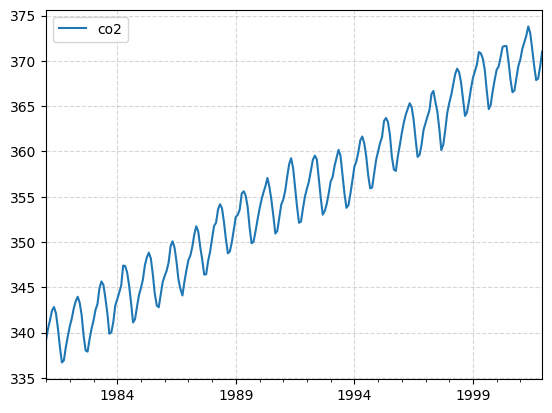

In [2]:
import matplotlib.pyplot as plt
#見やすいようにグラフの大きさを調整
plt.figure(figsize=(10, 5))
co2_data.plot()

# グリッド線を追加
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

STL分解

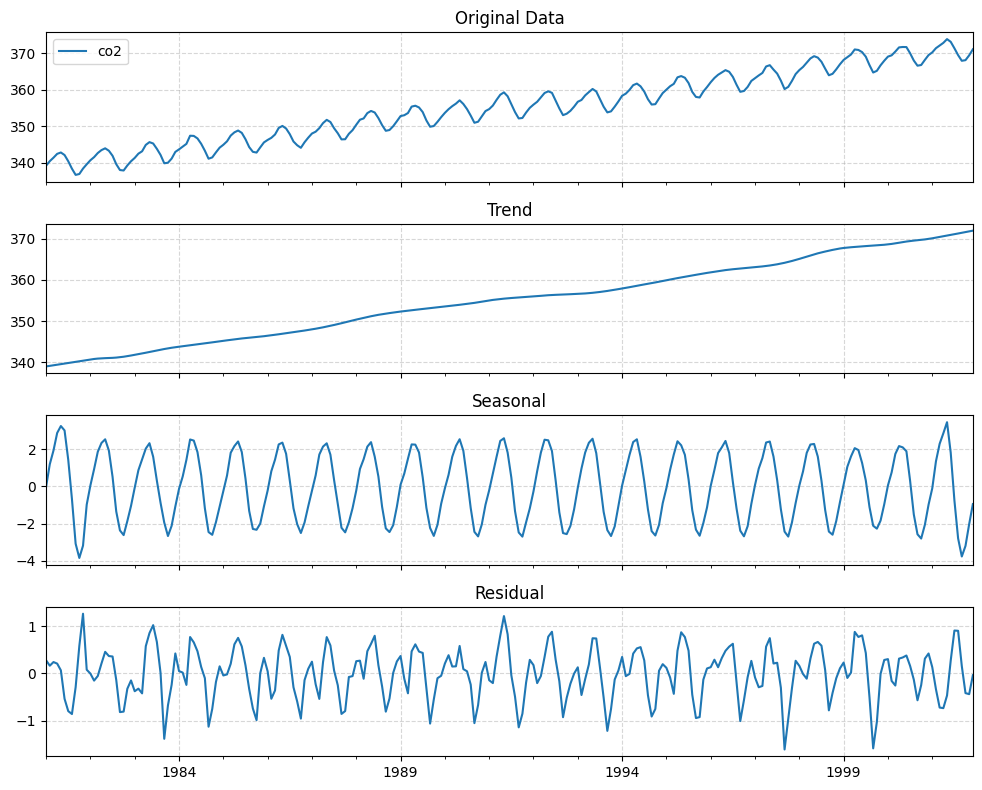

In [3]:
from statsmodels.tsa.seasonal import STL

# STL分解
stl = STL(co2_data, period=11)
res = stl.fit()

# それぞれの成分を描画
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

co2_data.plot(ax=axes[0])
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_title('Original Data')

res.trend.plot(ax=axes[1])
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_title('Trend')

res.seasonal.plot(ax=axes[2])
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].set_title('Seasonal')

res.resid.plot(ax=axes[3])
axes[3].grid(True, linestyle='--', alpha=0.5)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

それでは、STL分解の結果を順に確認していきましょう。

トレンド成分(Trend)を見ることで、データの長期的な傾向を確認することができます。
トレンドは不規則に上下しているように見えますが、この期間では緩やかに増加傾向にあると見て取れます。

季節成分(Seasonal)を見ることで、データの季節的な性質を確認することができます。
STL分解を行ってから確認すると、より明白に季節性の存在を確認できます。

残差成分(Residual)は、予測誤差やノイズを表しますが、不規則な形をしています。

STL分解することにより、データの傾向が掴みやすくなったことがわかります。

定常性の確認：ADF検定

In [4]:
#ADF検定を行うことができるモジュールをインポート
from statsmodels.tsa.stattools import adfuller

# ADF検定を実行
result = adfuller(co2_data)

# 結果を表示
print('統計検定量\t: %f' % result[0])
print('p値\t: %f' % result[1])
print('臨界値\t:')
for key, value in result[4].items():
    print('\t%s\t: %.3f' % (key, value))

# p値を評価
if result[1] < 0.05:
    print("時系列データは定常であると考えられます。")
else:
    print("時系列データは定常であるとは言えません。")

統計検定量	: -0.091566
p値	: 0.950272
臨界値	:
	1%	: -3.458
	5%	: -2.874
	10%	: -2.573
時系列データは定常であるとは言えません。


定常なデータに変換する目的で差分を取る

251


<Figure size 1000x500 with 0 Axes>

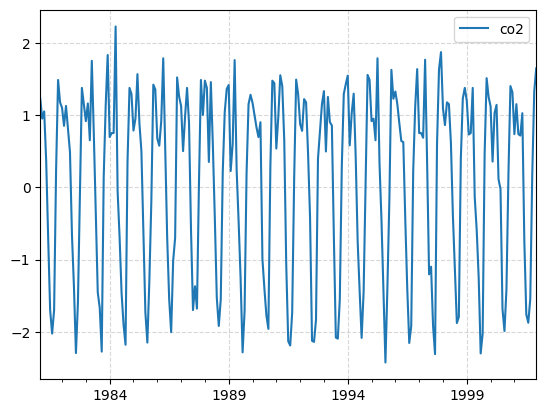

In [5]:
#隣り合う時点の差のデータを作成
co2_data_diff = co2_data.diff().dropna()

#見やすいようにグラフの大きさを調整
plt.figure(figsize=(10, 5))

#表示
co2_data_diff.plot()

#長さを表示
print(len(co2_data_diff))
# グリッド線を追加
plt.grid(True, linestyle='--', alpha=0.5)

STL分解での確認

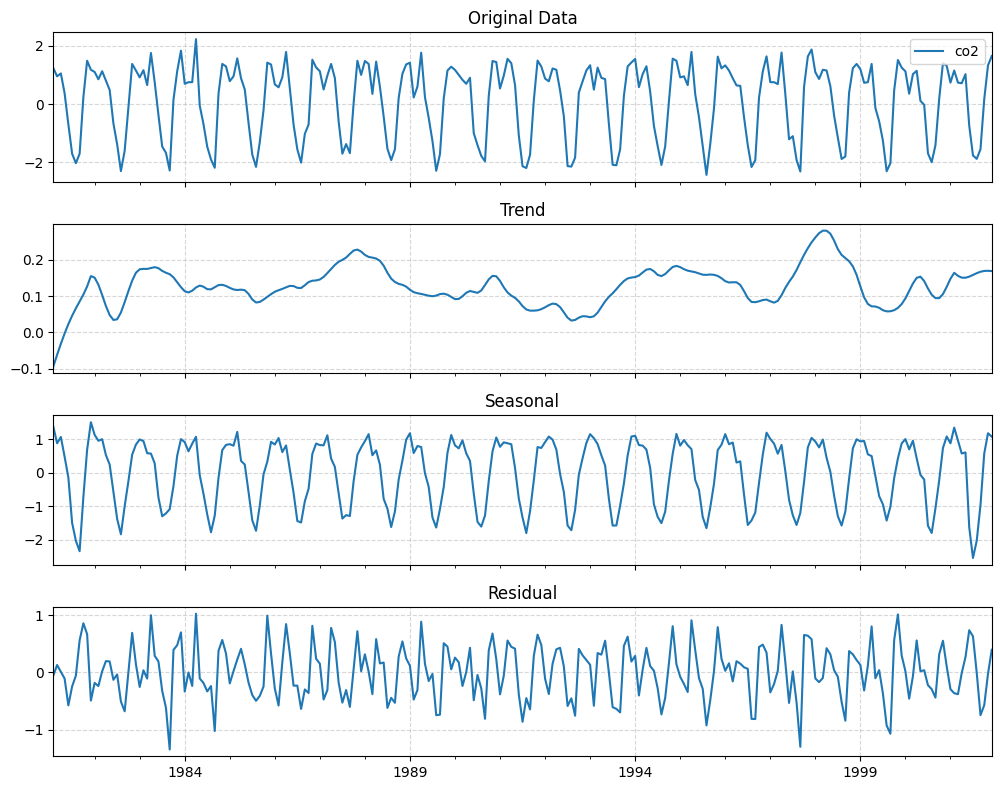

In [6]:
from statsmodels.tsa.seasonal import STL

# STL分解
stl = STL(co2_data_diff, period=11)
res = stl.fit()

# それぞれの成分を描画
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

co2_data_diff.plot(ax=axes[0])
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].set_title('Original Data')

res.trend.plot(ax=axes[1])
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].set_title('Trend')

res.seasonal.plot(ax=axes[2])
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].set_title('Seasonal')

res.resid.plot(ax=axes[3])
axes[3].grid(True, linestyle='--', alpha=0.5)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [7]:
#ADF検定を行うことができるモジュールをインポート
from statsmodels.tsa.stattools import adfuller

# ADF検定を実行
result = adfuller(co2_data_diff)

# 結果を表示
print('統計検定量\t: %f' % result[0])
print('p値\t: %f' % result[1])
print('臨界値\t:')
for key, value in result[4].items():
    print('\t%s\t: %.3f' % (key, value))

# p値を評価
if result[1] < 0.05:
    print("時系列データは定常であると考えられます。")
else:
    print("時系列データは定常であるとは言えません。")

統計検定量	: -3.505911
p値	: 0.007837
臨界値	:
	1%	: -3.458
	5%	: -2.874
	10%	: -2.573
時系列データは定常であると考えられます。


自己相関の確認

元データ

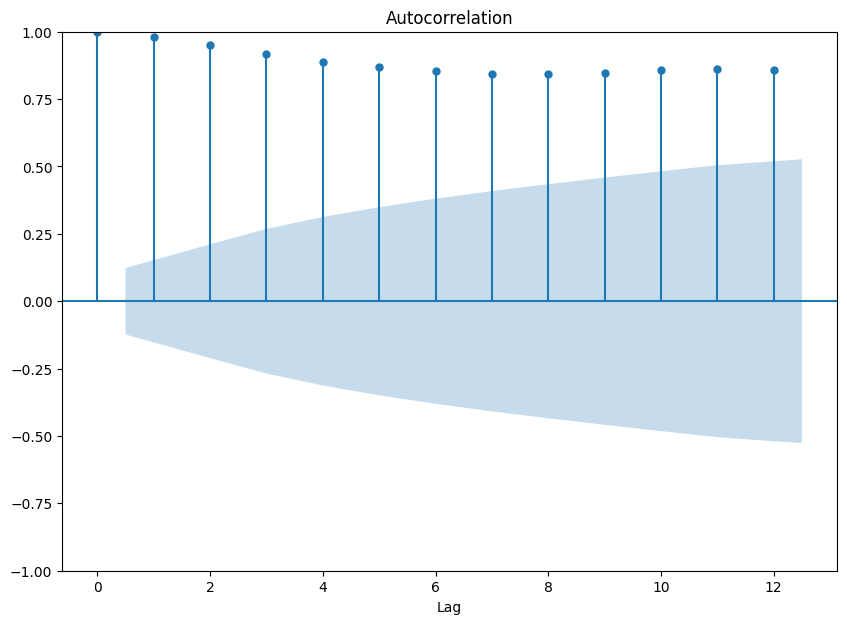

In [8]:
#自己相関を計算・プロットするplot_acf関数をインポート
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(10, 7))
#自己相関をプロット。lags=12と指定することによって、1年分(1周期分)の自己相関を計算
plot_acf(co2_data, lags=12, ax = ax)
plt.xlabel('Lag')
plt.show()

差分を取ったデータでも確認

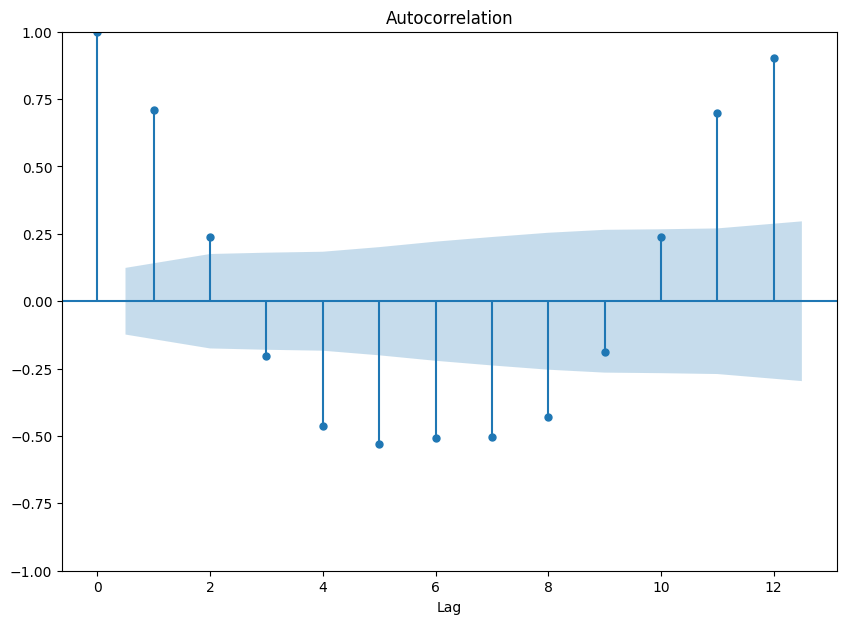

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
#自己相関をプロット。lags=12と指定することによって、1年分(1周期分)の自己相関を計算
plot_acf(co2_data_diff, lags=12, ax = ax)
plt.xlabel('Lag')
plt.show()

時系列順のデータなので、testに未来のデータのリークがないように分割

In [10]:
# 訓練データとテストデータを準備
len_test = 12
train = co2_data[:len(co2_data) -len_test]
test = co2_data[len(co2_data)-len_test:]

AICを用いたグリッドサーチによるモデルの最適なパラメタを探索（講義中には実行しない）

In [11]:
#このセルの実行には時間がかかります(5,6分)
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# まずはモデルのパラメータの範囲を設定します
max_ar = 12  # ARの最大次数
max_ma = 3  # MAの最大次数

# 最小AICを無限大で初期化します
best_aic = np.inf
best_order = None

# すべてのパラメータの組み合わせに対してモデルをフィットします
for p in range(max_ar+1):
    for q in range(max_ma+1):
        try:
            # モデルを作成
            # pが予測に用いる過去の観測値の数、qが予測に用いる過去の誤差項の数です
            tmp_mdl = ARIMA(train, order=(p, 1, q))
            result = tmp_mdl.fit()
            tmp_aic = result.aic
            # AICが小さい場合は、モデルとパラメータを更新します
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (p, q)
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 194.40797 | order: (12, 2)


ARIMAによる推論

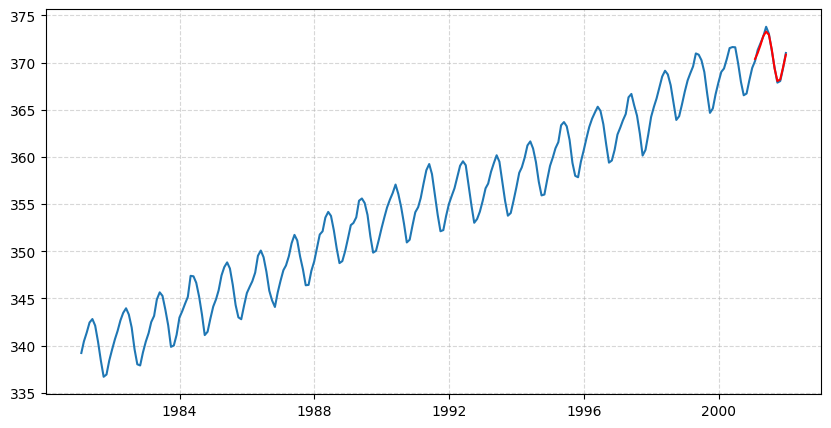

In [12]:
from statsmodels.tsa.arima.model import ARIMA

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.grid(True, linestyle='--', alpha=0.5)

#AICにおいてグリッドサーチを行い得られた結果から、p = 12, q = 2としてARMAモデルにて予測を行います
#order=(12, 1, 2)における1は、一回差分を意味します
arma_model = ARIMA(train, order=(12, 1, 2))
result = arma_model.fit()
forecast = result.forecast(len_test)

#青線（デフォルト）で大元のデータを表示
ax.plot(co2_data, ls="-")
#赤線で予測結果を表示
ax.plot(forecast, ls="-", color="r", label="predicted")

In [13]:
from sklearn.metrics import mean_squared_error

# 予測データと実際のデータのMSEを計算
mse = mean_squared_error(test, forecast)

print("Mean Squared Error:", mse)

Mean Squared Error: 0.047751478593390184


おまけ：ARMAやベンチマーク(今回は直近の値を予測値とする)による精度の比較

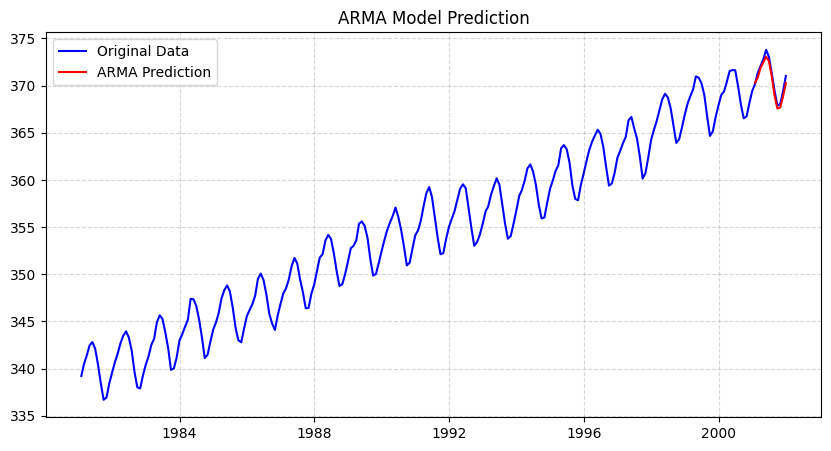

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# ARMAモデルの構築（差分を取らない = d=0）
arma_model = ARIMA(train, order=(12, 0, 2))  # p=12, q=2 を例に
result = arma_model.fit()

# 予測
forecast = result.forecast(steps=len_test)

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.grid(True, linestyle='--', alpha=0.5)

# 元データ
ax.plot(co2_data, label="Original Data", color="blue")
# ARMA予測
ax.plot(forecast, label="ARMA Prediction", color="red")

ax.legend()
plt.title("ARMA Model Prediction")
plt.show()

In [15]:
# テストデータと予測値
mse = mean_squared_error(test, forecast)
print(f"MSE: {mse}")

MSE: 0.21637415337274413


In [16]:
#直近の観測値を予測値とする
random_walk_forecast = [train.iloc[-1]] * len_test
mse_random_walk = mean_squared_error(test, random_walk_forecast)
print(f"MSE (Random Walk Model): {mse_random_walk}")

MSE (Random Walk Model): 5.376685416666625
